Plot time series and extract modes from a text file:

In [1]:
### Libraries ###

import os, sys
from git import Repo
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks  
from scipy.ndimage import gaussian_filter1d

In [2]:
#### Functions ####

def push_to_github(repo_path, commit_message):
    try:
        # Initialize the repo object
        repo = Repo(repo_path)
        
        # Stage all changes (or specify files like output_dir + "*.png")
        repo.git.add(all=True)
        
        # Commit
        now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        full_message = f"{commit_message} - {now}"
        repo.index.commit(full_message)
        
        # Push
        origin = repo.remote(name='origin')
        origin.push(refspec='main:main')
        
        print("Successfully pushed to GitHub!")
    except Exception as e:
        print(f"Error pushing to GitHub: {e}")

def fourier_transform(time_ms, rho, n_freq=3000):


    # Convert to numpy arrays
    t = np.asarray(time_ms)
    rho = np.asarray(rho)

    # Sort by time
    idx = np.argsort(t)
    t = t[idx]
    rho = rho[idx]

    # Remove duplicate time stamps (ESSENTIAL)
    unique_mask = np.diff(t, prepend=t[0] - 1.0) > 0
    t = t[unique_mask]
    rho = rho[unique_mask]

    # Time differences
    dt_all = np.diff(t)
    dt_min = np.min(dt_all[dt_all > 0])

    # Total duration (ms)
    T = t[-1] - t[0]

    # Frequency grid in kHz (1/ms)
    f_min = 1.0 / T
    f_max = 0.5 / dt_min
    freq_kHz = np.linspace(1, 9, n_freq)

    # Trapezoidal integration weights (ms)
    dt = np.zeros_like(t)
    dt[1:-1] = 0.5 * (t[2:] - t[:-2])
    dt[0] = t[1] - t[0]
    dt[-1] = t[-1] - t[-2]

    # Fourier transform (integral definition)
    rho_tilde = np.array([
        np.sum(rho * np.exp(-2j * np.pi * f * t) * dt)
        for f in freq_kHz
    ])

    power = np.abs(rho_tilde)**2

    return freq_kHz, power

def detect_star_surface(folder, filename="hydrobase-rho.x.asc", rho_floor=1e-10, time_col=8, x_col=9, rho_col=12, verbose=True):

    if verbose:
        print(f"Looking for files in the folder: {folder}")

    # Preserve caller's working directory
    cwd = os.getcwd()
    try:
        os.chdir(folder)

        if verbose:
            print(f"Opening file: {filename}.....")

        data = np.loadtxt(filename, comments='#')

    finally:
        os.chdir(cwd)

    if verbose:
        print("Reading file....")

    # --- pick initial time slice ---
    t0 = np.min(data[:, time_col])
    mask_t0 = data[:, time_col] == t0
    data_t0 = data[mask_t0]

    # --- extract x and rho ---
    x = data_t0[:, x_col]
    rho = data_t0[:, rho_col]

    # --- remove atmosphere / vacuum ---
    mask_star = rho > rho_floor
    x_star = x[mask_star]
    rho_star = rho[mask_star]  # kept for consistency / future use

    # --- unique spatial points define ixd ---
    x_p = np.unique(x_star)
    x_p.sort()

    N_ixd = len(x_p)
    surface_ixd = N_ixd - 1
    surface_x = x_p[-1]

    if verbose:
        print(f"Number of valid points: {N_ixd}")
        print(f"Physical Surface detected at x ≈ {surface_x:.4f}")
        print(f"surface index: {surface_ixd}")

    return x_p, surface_ixd, surface_x

def load_time_series(file_path):
    t_s_all = []
    rho_all = []
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Process two lines at a time
    for k in range(0, len(lines), 2):
        t_s = np.fromstring(lines[k], sep=" ") ##devide by 203 for lean bssn
        rho = np.fromstring(lines[k+1], sep=" ")

        t_s_all.append(t_s)
        rho_all.append(rho)

    # Convert to object arrays (ragged arrays)
    t_s_all = np.array(t_s_all, dtype=object)
    rho_all = np.array(rho_all, dtype=object)

    print("len(t_s_all): ", len(t_s_all))
    print("len(rho_all): ", len(rho_all))
    return np.array(t_s_all), np.array(rho_all)

#### Directories ####
output_dir = "/home/hsolanki/Programs/My-Work/output/"

adm = "/home/hsolanki/simulations/Pol_sim/output-0000/tov_ET"
lean_low = "/home/hsolanki/simulations/lean_bssn/output-0001/tov_ET"
lean_mid = "/home/hsolanki/simulations/lean_bssn_mid/output-0000/tov_ET"
lean_high = "/home/hsolanki/simulations/lean_high/output-0000/tov_ET"

file_path = output_dir + "rho_timeseries_lean_low.txt"
file_path_1 = output_dir + "rho_timeseries_lean_mid.txt"
file_path_2 = output_dir + "rho_timeseries_lean_high.txt"
file_path_adm = output_dir + "rho_timeseries_P.txt"

In [3]:
# Detect star surface to get x_p
x_p_l, surface_ixd_l, surface_x_l = detect_star_surface(lean_low, filename="hydrobase-rho.x.asc") 
x_p_m, surface_ixd_m, surface_x_m = detect_star_surface(lean_mid, filename="hydrobase-rho.x.asc") 
x_p_h, surface_ixd_h, surface_x_h = detect_star_surface(lean_high, filename="hydrobase-rho.x.asc") 

#x_P_P, surface_ixd_p, surface_x_p = detect_star_surface(sim_dir_p, filename="hydrobase-rho.x.asc") 

t_s_all_l, rho_all_l = load_time_series(file_path)
t_s_all_m, rho_all_m = load_time_series(file_path_1)
t_s_all_h, rho_all_h = load_time_series(file_path_2)
#t_s_all_P, rho_all_P = load_time_series(file_path_adm)

t_s_all_l = t_s_all_l / 203  # convert to ms
t_s_all_m = t_s_all_m / 203  # convert to ms
t_s_all_h = t_s_all_h / 203  # convert to ms

#t_s_all_P = t_s_all_P / 203  # convert to ms

Looking for files in the folder: /home/hsolanki/simulations/lean_bssn/output-0001/tov_ET
Opening file: hydrobase-rho.x.asc.....
Reading file....
Number of valid points: 23
Physical Surface detected at x ≈ 17.5000
surface index: 22
Looking for files in the folder: /home/hsolanki/simulations/lean_bssn_mid/output-0000/tov_ET
Opening file: hydrobase-rho.x.asc.....
Reading file....
Number of valid points: 39
Physical Surface detected at x ≈ 14.7500
surface index: 38
Looking for files in the folder: /home/hsolanki/simulations/lean_high/output-0000/tov_ET
Opening file: hydrobase-rho.x.asc.....
Reading file....
Number of valid points: 61
Physical Surface detected at x ≈ 13.6500
surface index: 60
len(t_s_all):  23
len(rho_all):  23
len(t_s_all):  39
len(rho_all):  39
len(t_s_all):  61
len(rho_all):  61


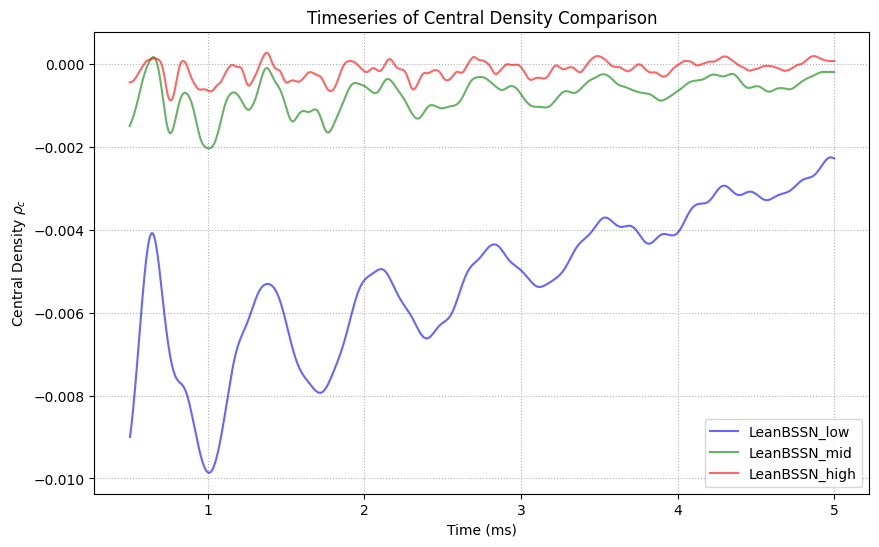

In [4]:
### Time_series Check ###
ik = 0

t_l = t_s_all_l[ik]
rho_l = rho_all_l[ik]

t_m = t_s_all_m[ik]
rho_m = rho_all_m[ik]

t_h = t_s_all_h[ik]
rho_h = rho_all_h[ik]

# t_adm = t_s_all_P[ik]
# rho_adm = rho_all_P[ik]

lim_l = (t_l >= 0.5) & (t_l <= 5)
lim_m = (t_m >= 0.5) & (t_m <= 5)
lim_h = (t_h >= 0.5) & (t_h <= 5)

#lim_adm = (t_adm >= 0.5) & (t_adm <= 5)

t_l = t_l[lim_l]
rho_l = rho_l[lim_l]

t_m = t_m[lim_m]
rho_m = rho_m[lim_m]

t_h = t_h[lim_h]
rho_h = rho_h[lim_h]
#t_adm = t_adm[lim_adm]
#rho_adm = rho_adm[lim_adm]


plt.figure(figsize=(10,6))
plt.plot(t_l, rho_l, label="LeanBSSN_low", color="blue", alpha=0.6)
plt.plot(t_m, rho_m, label="LeanBSSN_mid", color="green", alpha=0.6)
plt.plot(t_h, rho_h, label="LeanBSSN_high", color="red", alpha=0.6)
plt.xlabel("Time (ms)")
plt.ylabel(r"Central Density $\rho_c$")
plt.title("Timeseries of Central Density Comparison")
plt.grid(True, linestyle=":")
plt.legend()
plt.show()
#plt.savefig(output_dir + "time_series_comparision.png", dpi=300)

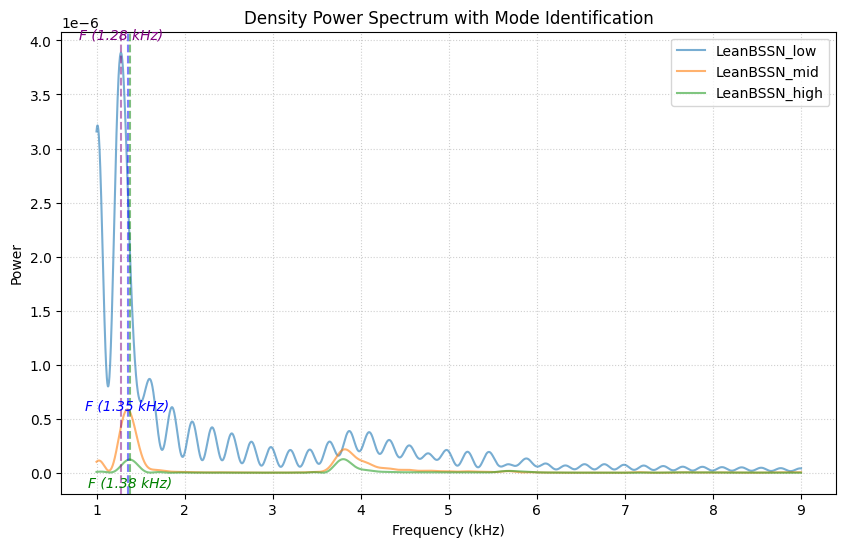

In [6]:
#### Mode Extraction ####

freq_l, power_l = fourier_transform(t_l, rho_l)
freq_m, power_m = fourier_transform(t_m, rho_m)
freq_h, power_h = fourier_transform(t_h, rho_h)
#freq_adm, power_adm = fourier_transform(t_adm, rho_adm)



peaks_l, properties = find_peaks(
    power_l,
    height=np.max(power_l) * 0.07,
    prominence=np.percentile(power_l, 95) * 0.15,
    width=6,
)

peaks_m, properties = find_peaks(
    power_m,
    height=np.max(power_m) * 0.07,
    prominence=np.percentile(power_m, 95) * 0.35,
    width=8,
)

peaks_h, properties = find_peaks(
    power_h,
    height=np.max(power_h) * 0.07,
    prominence=np.percentile(power_h, 95) * 0.35,
    width=8,
)

F_c_l = freq_l[peaks_l[0]]  # Frequency of fundamental mode in kHz
F_c_m = freq_m[peaks_m[0]]  # Frequency of fundamental mode in kHz
F_c_h = freq_h[peaks_h[0]]  # Frequency of fundamental mode in kHz
labels = ["F"]

# --- Plotting the Raw Comparison ---
plt.figure(figsize=(10, 6))

# --- plot PSDs ---
plt.plot(freq_l, power_l, alpha=0.6, label="LeanBSSN_low")
plt.plot(freq_m, power_m, alpha=0.6, label="LeanBSSN_mid")
plt.plot(freq_h, power_h, alpha=0.6, label="LeanBSSN_high")
# --- package peak information ---
spectra = [
    {
        "freq": freq_l,
        "power": power_l,
        "peaks": peaks_l,
        "labels": labels,
        "color": "purple",
        "name": "LeanBSSN",
        "yoffset": 10
    },
    {
        "freq": freq_m,
        "power": power_m,
        "peaks": peaks_m,
        "labels": labels,
        "color": "blue",
        "name": "LeanBSSN_mid",
        "yoffset": 0
    },
    {
        "freq": freq_h,
        "power": power_h,
        "peaks": peaks_h,
        "labels": labels,
        "color": "green",
        "name": "LeanBSSN_high",
        "yoffset": -20
    }
]

# --- annotate peaks ---
for spec in spectra:
    for i, peak_idx in enumerate(spec["peaks"][:len(spec["labels"])]):
        x = spec["freq"][peak_idx]
        y = spec["power"][peak_idx]

        plt.axvline(
            x=x,
            color=spec["color"],
            linestyle="--",
            alpha=0.5
        )

        plt.annotate(
            f"{spec['labels'][i]} ({x:.2f} kHz)",
            xy=(x, y),
            xytext=(0, spec["yoffset"]),
            textcoords="offset points",
            ha="center",
            fontstyle="italic",
            color=spec["color"]
        )

plt.xlabel("Frequency (kHz)")
plt.ylabel("Power")
plt.title("Density Power Spectrum with Mode Identification")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
#plt.savefig(output_dir+"lean_psd_beta_1.png")
plt.show()


Looking for files in the folder: /home/hsolanki/simulations/lean_2/output-0000/tov_ET
Opening file: hydrobase-rho.x.asc.....
Reading file....
Number of valid points: 39
Physical Surface detected at x ≈ 14.7500
surface index: 38
1: 3656 → 2: 1828 after removing duplicates
1: 1828 → 2: 1828 after removing duplicates
1: 3656 → 2: 1828 after removing duplicates
1: 1828 → 2: 1828 after removing duplicates
1: 3656 → 2: 1828 after removing duplicates
1: 1828 → 2: 1828 after removing duplicates
1: 3656 → 2: 1828 after removing duplicates
1: 1828 → 2: 1828 after removing duplicates
1: 3656 → 2: 1828 after removing duplicates
1: 1828 → 2: 1828 after removing duplicates
1: 3656 → 2: 1828 after removing duplicates
1: 1828 → 2: 1828 after removing duplicates
1: 3656 → 2: 1828 after removing duplicates
1: 1828 → 2: 1828 after removing duplicates
1: 5484 → 2: 1828 after removing duplicates
1: 3656 → 2: 1828 after removing duplicates
1: 5484 → 2: 1828 after removing duplicates
1: 3656 → 2: 1828 after 

Text(0, 0.5, '$\\tilde{\\rho}_F(r)$')

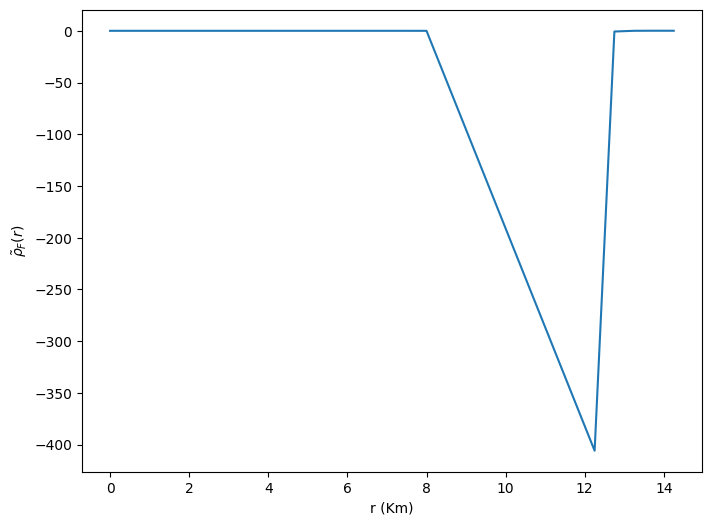

In [71]:
### Eigenfunction Extraction ###

    #Detect star surface to get x_p
x_p, surface_ixd_l, surface_x = detect_star_surface(sim_dir_lean, filename="hydrobase-rho.x.asc") 


F_amp_complex = []
F_freq = []

for i in range(0, 38):

    t_s = t_s_all_l[i]
    rho = rho_all_l[i]
    lim = (t_s >= 0.5) & (t_s <= 5)
    t_s = t_s[lim]
    rho = rho[lim]

    #### FFT ####

    freq, power = fourier_transform(t_s, rho)
    peaks, properties = find_peaks(
        power,
        height=np.max(power) * 0.07,
        prominence=np.percentile(power, 95) * 0.35,
        width=8,
    )                                # suppress narrow noise spikes 3.5

    # f_F = freq[peaks[0]]  # Frequency of fundamental mode in kHz
    # F_freq.append(f_F)
    # print(f"Point {i}: F_mode = {f_F} kHz")
    f_F = F_c_l

    # Remove duplicate / non-increasing times
    unique_mask = np.diff(t_s, prepend=t_s[0] - 1.0) > 0

    t = t_s[unique_mask]
    rho = rho[unique_mask]

    print(f"1: {len(t_s)} → 2: {len(t)} after removing duplicates")

    # Trapezoidal weights
    dt = np.zeros_like(t)
    dt[1:-1] = 0.5 * (t[2:] - t[:-2])
    dt[0] = t[1] - t[0]
    dt[-1] = t[-1] - t[-2]

    # Projection onto F-mode
    rho_tilde_F = np.sum(
        rho * np.exp(-2j * np.pi * f_F * t) * dt
    )

    F_amp_complex.append(rho_tilde_F)
    #print(f"amp_F = {abs(rho_tilde_F)}")

F_amp_complex = np.array(F_amp_complex)


eig = np.real(F_amp_complex)


# Radius
r = x_p[:len(eig)]

# Plot
plt.figure(figsize=(8,6))
plt.plot(r,eig)
plt.xlabel("r (Km)")
plt.ylabel(r"$\tilde{\rho}_F(r)$")